In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.util import ngrams
nltk.download('punkt')
import re

DATA_PATH = '/dataset/re_dataset.csv'
KAMUS_PATH = '/dataset/new_kamusalay.csv'

def convert_to_utf8(input_path, output_path):
    with open(input_path, 'rb') as f:
        raw = f.read()

    clean = raw.decode('latin1')

    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(clean)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
TEMP_DATA = '/dataset/re_dataset_utf8.csv'
TEMP_KAMUS = '/dataset/kamusalay_utf8.csv'

convert_to_utf8(DATA_PATH, TEMP_DATA)
convert_to_utf8(KAMUS_PATH, TEMP_KAMUS)

In [7]:
df = pd.read_csv(TEMP_DATA, encoding="utf-8")
kamus = pd.read_csv(TEMP_KAMUS, encoding="utf-8", header=None, names=['alay','baku'])

alay_dict = dict(zip(kamus['alay'], kamus['baku']))

In [8]:
def normalize_text(text):
    # Handle nilai kosong
    if pd.isna(text):
        return ""

    # Ubah ke huruf kecil
    text = text.lower()

    # Hapus token user dan url
    text = re.sub(r"\buser\b", "", text)
    text = re.sub(r"\burl\b", "", text)

    # Hapus link
    text = re.sub(r"http\S+|www.\S+", "", text)

    # Hapus noise karakter heksadesimal
    text = re.sub(r'\bx[0-9a-f]{2}\b', ' ', text)

    # Kurangi huruf berulang
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Hapus karakter non-alfanumerik
    text = re.sub(r"[^a-z0-9\s]", " ", text)

    # Tokenisasi dan normalisasi kata alay
    words = text.split()
    words = [alay_dict.get(word, word) for word in words]

    # Gabungkan kembali kata
    return " ".join(words)

In [9]:
# Applu fungsi normalize ke kolom Tweet
df['clean_text'] = df['Tweet'].astype(str).apply(normalize_text)

# Tampilkan teks asli dan hasil pembersihan
df[['Tweet', 'clean_text']].head()

,Tweet,clean_text
0,- disaat semua cowok berusaha melacak perhatia...,di saat semua cowok berusaha melacak perhatian...
1,RT USER: USER siapa yang telat ngasih tau elu?...,rt siapa yang telat memberi tau kamu edan sara...
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",41 kadang aku berpikir kenapa aku tetap percay...
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,aku itu aku dan ku tau matamu sipit tapi dilih...
4,USER USER Kaum cebong kapir udah keliatan dong...,kaum cebong kafir sudah kelihatan dongoknya da...


In [18]:
# Membuat label akhir: 1 jika HS atau Abusive bernilai 1, selain itu 0
df['label'] = df[['HS', 'Abusive']].max(axis=1)

# Menampilkan jumlah data per label
print(df['label'].value_counts())

# Menampilkan persentase distribusi label
print(df['label'].value_counts(normalize=True) * 100)

label
1    7309
0    5860
Name: count, dtype: int64
label
1    55.501557
0    44.498443
Name: proportion, dtype: float64


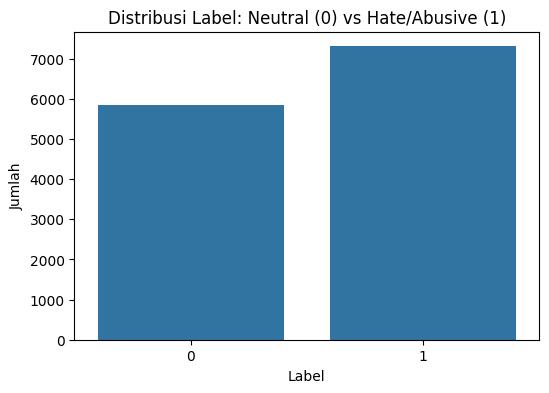

In [19]:
# =========================================================
# Distribusi Label
# =========================================================
plt.figure(figsize=(6,4))
# Plot jumlah data untuk setiap label
sns.countplot(data=df, x='label')

# Judul dan label sumbu
plt.title("Distribusi Label: Neutral (0) vs Hate/Abusive (1)")
plt.xlabel("Label")
plt.ylabel("Jumlah")

plt.show()

Berdasarkan visualisasi, terlihat bahwa:

- Jumlah data dengan label 1 (Hate/Abusive) lebih banyak dibandingkan label 0 (Neutral).

- Hal ini menunjukkan adanya ketidakseimbangan kelas (class imbalance), meskipun tidak terlalu ekstrem.

Distribusi seperti ini penting untuk diperhatikan karena:

- Model klasifikasi cenderung lebih bias ke kelas mayoritas jika tidak ditangani dengan baik.

- Diperlukan evaluasi menggunakan metrik yang sesuai, seperti precision, recall, dan F1-score, bukan hanya akurasi.

- Secara keseluruhan, plot ini memberikan gambaran awal bahwa dataset memiliki proporsi data hate/abusive yang relatif dominan, sehingga strategi pelatihan model perlu mempertimbangkan kondisi tersebut.

In [20]:
# =========================================================
# contoh Teks per Label
# =========================================================

# Tampilkan contoh teks berlabel Neutral (0)
print("\nContoh Neutral:")
print(df[df['label'] == 0]['clean_text'].head(5).tolist())

# Tampilkan contoh teks berlabel Hate/Abusive (1)
print("\nContoh Hate/Abusive:")
print(df[df['label'] == 1]['clean_text'].head(5).tolist())


Contoh Neutral:
['41 kadang aku berpikir kenapa aku tetap percaya pada tuhan padahal aku selalu jatuh berkali kali kadang aku merasa tuhan itu meninggalkan aku sendirian ketika orang tuaku berencana berpisah ketika kakakku lebih memilih jadi kristen ketika aku anak ter', 'aku itu aku dan ku tau matamu sipit tapi dilihat dari mana itu aku', 'deklarasi pilihan kepala daerah 2018 aman dan anti hoaks warga dukuh sari jabon', 'nah admin belanja satu lagi port terbaik nak makan ais kepal milo ais kepal horlicks atau cendol toping kau kau doket mana itu gerai rozak mertuaku taipan 2 depan kembar baby amp romantika bank islam senawang', 'kalau belajar ekonomi mestinya jago memprivatisasi hati orang aduh ironi']

Contoh Hate/Abusive:
['di saat semua cowok berusaha melacak perhatian gue kamu lantas remehkan perhatian yang gue kasih khusus ke kamu basic kamu cowok bego', 'rt siapa yang telat memberi tau kamu edan sarap gue bergaul dengan cigax jifla calis sama siapa itu licew juga', 'kaum cebong

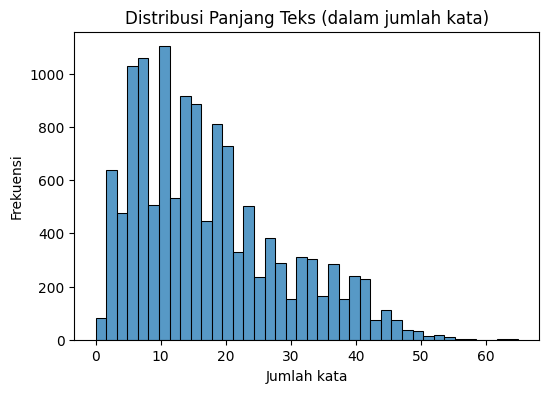

count    13169.000000
mean        17.426000
std         11.314944
min          0.000000
25%          9.000000
50%         15.000000
75%         24.000000
max         65.000000
Name: text_len, dtype: float64


In [21]:
# =========================================================
# Analisis Panjang Teks
# =========================================================

# Hitung panjang teks berdasarkan jumlah kata
df['text_len'] = df['clean_text'].apply(lambda x: len(str(x).split()))

# Visualisasi distribusi panjang teks
plt.figure(figsize=(6,4))
sns.histplot(df['text_len'], bins=40)

# Judul dan label sumbu
plt.title("Distribusi Panjang Teks (dalam jumlah kata)")
plt.xlabel("Jumlah kata")
plt.ylabel("Frekuensi")

plt.show()

# Statistik deskriptif panjang teks
print(df['text_len'].describe())

Distribusi panjang teks bersifat right-skewed, di mana sebagian besar data berada pada rentang 5–20 kata. Frekuensi tertinggi muncul sekitar 8–12 kata, menunjukkan mayoritas teks tergolong pendek. Hanya sedikit teks yang memiliki panjang di atas 40 kata, yang dapat dianggap sebagai outlier. Berdasarkan distribusi ini, panjang sequence 40–50 kata sudah cukup untuk merepresentasikan hampir seluruh data secara efisien.

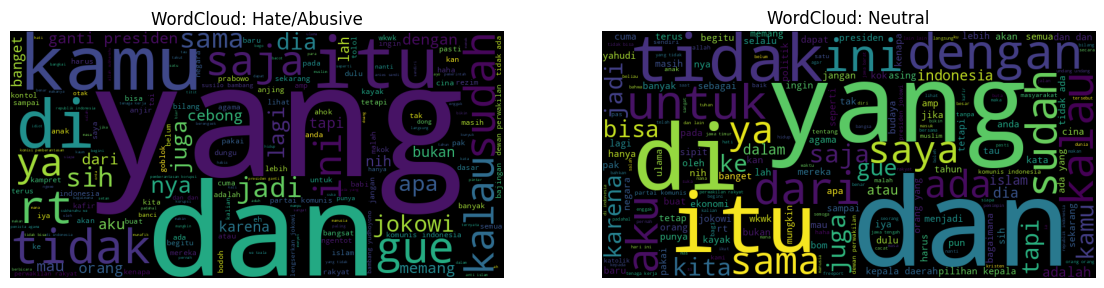

In [23]:
# =========================================================
# WordCloud untuk Analisis Kata
# =========================================================
from wordcloud import WordCloud

# Gabungkan seluruh teks Hate/Abusive menjadi satu string
hate_text = " ".join(df[df['label'] == 1]['clean_text'].tolist())

# Gabungkan seluruh teks Neutral menjadi satu string
neutral_text = " ".join(df[df['label'] == 0]['clean_text'].tolist())

plt.figure(figsize=(14,6))

# WordCloud untuk label Hate/Abusive
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=800, height=400).generate(hate_text))
plt.title("WordCloud: Hate/Abusive")
plt.axis("off")

# WordCloud untuk label Neutral
plt.subplot(1,2,2)
plt.imshow(WordCloud(width=800, height=400).generate(neutral_text))
plt.title("WordCloud: Neutral")
plt.axis("off")

plt.show()

Penjelasan plot WordCloud:

- Hate/Abusive: Didominasi kata kasar, provokatif, dan bernuansa menyerang (mis. anjing, bodoh, goblok), menunjukkan ekspresi emosi negatif dan serangan personal.

- Neutral: Didominasi kata umum dan netral (mis. yang, itu, saya, dengan), mencerminkan percakapan informatif tanpa muatan emosional kuat.

Perbedaan ini menunjukkan kata kunci pada kelas Hate/Abusive lebih spesifik dan bermuatan emosi dibanding kelas Neutral.

In [25]:
# =========================================================
# Analisis N-gram (Bigram)
# =========================================================
from nltk.util import ngrams
from collections import Counter

# Fungsi untuk mengambil n-gram paling sering muncul
def get_top_ngrams(texts, n=20, gram=2):
    # Gabungkan seluruh teks dan tokenisasi
    tokens = " ".join(texts).split()

    # Bentuk n-gram (default: bigram)
    ng = ngrams(tokens, gram)

    # Hitung frekuensi kemunculan n-gram
    counter = Counter(ng)

    # Ambil n n-gram teratas
    return counter.most_common(n)

# Tampilkan 20 bigram teratas untuk label Neutral
print("\nTop 20 Bigram Neutral:")
print(get_top_ngrams(df[df['label'] == 0]['clean_text']))

# Tampilkan 20 bigram teratas untuk label Hate/Abusive
print("\nTop 20 Bigram Hate/Abusive:")
print(get_top_ngrams(df[df['label'] == 1]['clean_text']))


Top 20 Bigram Neutral:
[(('kepala', 'daerah'), 277), (('pilihan', 'kepala'), 263), (('tidak', 'ada'), 143), (('dan', 'dan'), 140), (('ada', 'yang'), 123), (('orang', 'yang'), 117), (('partai', 'komunis'), 111), (('komunis', 'indonesia'), 109), (('presiden', 'jokowi'), 94), (('dewan', 'perwakilan'), 90), (('perwakilan', 'rakyat'), 87), (('tenaga', 'kerja'), 83), (('undang', 'undang'), 81), (('orang', 'orang'), 80), (('hari', 'ini'), 80), (('tidak', 'bisa'), 76), (('lain', 'lain'), 76), (('yang', 'tidak'), 75), (('dan', 'lain'), 75), (('di', 'indonesia'), 71)]

Top 20 Bigram Hate/Abusive:
[(('ganti', 'presiden'), 381), (('2019', 'ganti'), 353), (('partai', 'komunis'), 266), (('komunis', 'indonesia'), 261), (('tidak', 'ada'), 144), (('dewan', 'perwakilan'), 122), (('perwakilan', 'rakyat'), 121), (('presiden', '2019'), 117), (('lengserkan', 'jokowi'), 116), (('dan', 'dan'), 116), (('susilo', 'bambang'), 112), (('bambang', 'yudhoyono'), 112), (('pemberantasan', 'korupsi'), 112), (('komisi'

Penjelasan Hasil Bigram:

- Neutral: Bigram didominasi frasa informatif dan institusional seperti kepala daerah, dewan perwakilan rakyat, undang undang, serta pola umum (tidak ada, orang yang). Ini menunjukkan konteks diskusi umum/berita tanpa serangan langsung.

- Hate/Abusive: Muncul bigram bernuansa politis dan provokatif seperti ganti presiden, lengserkan jokowi, penista agama, serta slogan kampanye. Ini mengindikasikan ujaran bernada konfrontatif dan emosional.

Perbedaan ini menunjukkan kelas Hate/Abusive lebih banyak mengandung frasa bernuansa serangan/agitasi dibanding kelas Neutral yang cenderung deskriptif.

In [26]:
# =========================================================
# Analisis Top Unigram, Bigram, dan Trigram
# =========================================================

from collections import Counter
from nltk.util import ngrams

# Fungsi untuk mengambil n-gram paling sering muncul
def get_top_ngram(corpus, n=1, top=20):
    # Gabungkan seluruh teks dan tokenisasi
    tokens = " ".join(corpus).split()

    # Bentuk n-gram sesuai nilai n
    ng = ngrams(tokens, n)

    # Hitung frekuensi kemunculan n-gram
    freq = Counter(ng)

    # Ambil n-gram teratas
    return freq.most_common(top)

# Top unigram pada data Hate/Abusive
print(get_top_ngram(df[df['label'] == 1]['clean_text'], n=1))

# Top bigram pada data Hate/Abusive
print(get_top_ngram(df[df['label'] == 1]['clean_text'], n=2))

# Top trigram pada data Hate/Abusive
print(get_top_ngram(df[df['label'] == 1]['clean_text'], n=3))

[(('yang',), 2177), (('dan',), 1862), (('tidak',), 1719), (('kamu',), 1455), (('di',), 1385), (('itu',), 1083), (('indonesia',), 890), (('rt',), 828), (('sudah',), 816), (('saja',), 791), (('gue',), 783), (('ini',), 780), (('kalau',), 779), (('presiden',), 773), (('jokowi',), 732), (('ya',), 680), (('orang',), 676), (('jadi',), 608), (('sama',), 594), (('sih',), 573)]
[(('ganti', 'presiden'), 381), (('2019', 'ganti'), 353), (('partai', 'komunis'), 266), (('komunis', 'indonesia'), 261), (('tidak', 'ada'), 144), (('dewan', 'perwakilan'), 122), (('perwakilan', 'rakyat'), 121), (('presiden', '2019'), 117), (('lengserkan', 'jokowi'), 116), (('dan', 'dan'), 116), (('susilo', 'bambang'), 112), (('bambang', 'yudhoyono'), 112), (('pemberantasan', 'korupsi'), 112), (('komisi', 'pemberantasan'), 110), (('republik', 'indonesia'), 109), (('anies', 'sandi'), 104), (('ada', 'yang'), 101), (('tidak', 'bisa'), 97), (('penista', 'agama'), 89), (('allah', 'subhanahu'), 77)]
[(('2019', 'ganti', 'presiden'

Penjelasan n-gram:

- Unigram: Didominasi kata fungsi dan percakapan umum (yang, dan, tidak, kamu, di), serta entitas/topik umum (indonesia, presiden, jokowi). Ini menunjukkan banyak konteks diskusi sehari-hari dan politik.

- Bigram: Muncul frasa politis dan slogan kuat seperti ganti presiden, partai komunis, lengserkan jokowi, yang mencerminkan narasi konfrontatif dan isu sensitif.

- Trigram: Frasa semakin spesifik dan bermuatan konteks kuat, misalnya 2019 ganti presiden, partai komunis indonesia, penista agama, menunjukkan pola ujaran terstruktur dan tema politik/ideologis yang dominan.

Secara keseluruhan, semakin tinggi n-gram, semakin jelas topik dan intensitas narasi, terutama pada konteks politis dan provokatif.

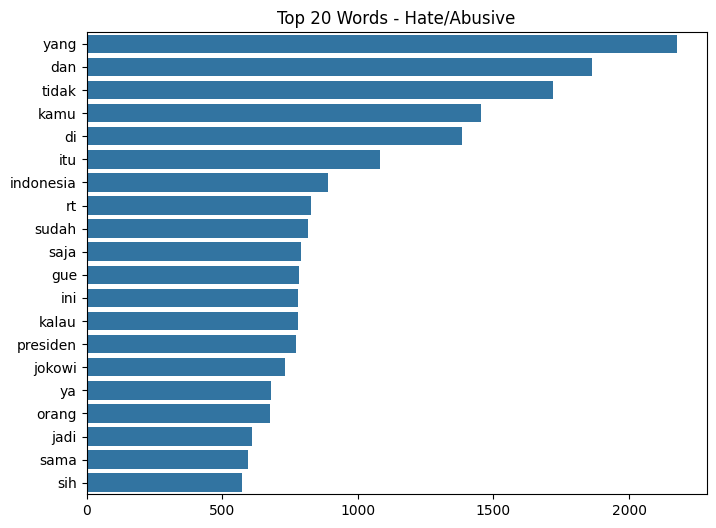

In [17]:
from collections import Counter
import seaborn as sns

counter = Counter(" ".join(df[df['label']==1]['clean_text']).split())
common = counter.most_common(20)

words, freq = zip(*common)

plt.figure(figsize=(8,6))
sns.barplot(x=freq, y=words)
plt.title("Top 20 Words - Hate/Abusive")
plt.show()

Penjelasan singkat Top Words – Hate/Abusive:

Kata yang paling sering muncul didominasi oleh kata umum dan kata fungsi seperti yang, dan, tidak, di, yang menunjukkan struktur kalimat percakapan. Munculnya kata pronomina seperti kamu, gue mengindikasikan ujaran yang bersifat langsung ke individu, yang umum pada teks hate/abusive. Selain itu, keberadaan kata bertopik politik seperti presiden dan jokowi menunjukkan bahwa ujaran kebencian banyak muncul dalam konteks diskusi politik.